In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import pywt
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch
import pickle
import os
from datetime import datetime
import sqlite3
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics.functional.classification.accuracy import accuracy


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on device: {device}')

Training on device: cuda


In [17]:
class CWTDataset(Dataset):
    def __init__(self, db_path, sequence_length=4000):
        self.db_path = db_path
        self.sequence_length = sequence_length
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.cursor.execute("SELECT COUNT(*) FROM wavelet_transforms")
        self.total_samples = self.cursor.fetchone()[0]

    def __len__(self):
        # Aby umożliwić nachodzenie, liczba możliwych sekwencji będzie równa liczbie próbek minus długość sekwencji + 1
        return self.total_samples - self.sequence_length + 1

    def __getitem__(self, idx):
        # Zwraca sekwencję próbek i target z ostatniej próbki
      
        query = (
            "SELECT cwt_data, target FROM wavelet_transforms WHERE id BETWEEN ? AND ?"
        )
        self.cursor.execute(
            query, (idx + 1, idx + self.sequence_length)
        )  # SQLite indeksuje od 1
        rows = self.cursor.fetchall()

        cwt_sequence = np.array([pickle.loads(row[0]) for row in rows])

        # Target ostatniej próbki w sekwencji
        target = rows[-1][1]

        cwt_tensor = torch.tensor(cwt_sequence, dtype=torch.float32)
        cwt_tensor = cwt_tensor.view(self.sequence_length,-1)
        target_tensor = torch.tensor(target, dtype=torch.int64)
        return cwt_tensor, target_tensor

    def __del__(self):
        self.conn.close()

In [18]:
from torch.utils.data import DataLoader

# Tworzenie instancji datasetu
cwt_dataset = CWTDataset('cwt_data.db', 4000)

# batch_size = 10  # Liczba sekwencji w jednym batchu
# train_loader = DataLoader(dataset=cwt_dataset, batch_size=batch_size, shuffle=True,num_workers=15)


In [19]:
cwt_dataset.__getitem__(0)[0].shape

torch.Size([4000, 640])

In [20]:
cwt_dataset.__getitem__(1)[0].shape

torch.Size([4000, 640])

In [21]:
cwt_dataset.__getitem__(2000)[1]

tensor(2)

In [22]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
#         super(LSTMModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim
#         self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
    
#     def forward(self, x):
#         # Inicjalizacja stanów ukrytych
#         h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
#         c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
        
#         # Forward pass through LSTM layer
#         out, (hn, cn) = self.lstm(x, (h0, c0))
        
#         # Forward pass through linear layer
#         out = self.fc(out[:, -1, :])
#         return out

In [23]:
# # Parametry
# input_dim = 640
# hidden_dim = 100
# layer_dim = 1
# output_dim = 1
# num_epochs = 20
# learning_rate = 0.01

# model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Pętla treningowa
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     for batch_idx, (data, targets) in enumerate(train_loader):
#         # Przeniesienie danych na GPU
#         data = data.view(-1, 4000, 640).to(device)
#         targets = targets.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(data)
        
#         loss = criterion(outputs, targets.float().unsqueeze(1))
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
#         print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
#     avg_train_loss = train_loss / len(train_loader)
#     # Walidacja
#     val_loss = evaluate_model(model, validation_loader, device)  # załóżmy, że mamy validation_loader

#     # Wyświetlanie postępów
#     print(f'Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')

#     # Zapisywanie modelu, gdy jest najlepszy na walidacji
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_model.pth')
#         print(f'Best model saved with validation loss: {val_loss:.4f}')


In [24]:
# DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=15)

In [47]:
class CWT_EEG(LightningModule):
    def __init__(
        self, batch_size,sequence_length, input_size, hidden_size, num_layers, lr, label_smoothing=0
    ):
        super().__init__()
        self.hparams.batch_size = batch_size
        self.hparams.input_size = input_size
        self.hparams.sequence_length = sequence_length
        self.hparams.lr = lr
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_of_classes = 3

        self.save_hyperparameters()
        self.val_percent = 0.2
        self.loss = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, self.num_of_classes)  # Klasyfikacja na 3 klasy

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # print(x.shape)
        #x = x.reshape(self.hparams.batch_size, self.hparams.sequence_length, -1)  # Wynikowy kształt: (10, 4000, 640)
        # print(x.shape)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = hn[-1, :, :]  # Ostatnia warstwa LSTM (batch_size, hidden_size)
        out = self.fc(out)

        return out

    # custom
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # only for HP
    def on_train_start(self):
        self.logger.log_hyperparams(
            self.hparams,
            {
                "hp/train_loss": float("nan"),
                "hp/train_acc": float("nan"),
                "hp/val_loss": float("nan"),
                "hp/val_acc": float("nan"),
            },
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_of_classes)

        self.log("hp/train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("hp/train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_of_classes)

        self.log("hp/val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("hp/val_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def setup(self, stage=None):
        self.ds = CWTDataset("cwt_data.db", self.hparams.sequence_length)
        train_indices, val_indices = self.create_train_val_split(len(self.ds), self.val_percent, self.hparams.sequence_length)

        self.train_set = torch.utils.data.Subset(self.ds, train_indices)
        self.val_set = torch.utils.data.Subset(self.ds, val_indices)

    def create_train_val_split(self, data_length, val_percent, sequence_length):
        val_count = int(val_percent * data_length)
        all_indices = np.arange(data_length)
        val_indices = np.sort(np.random.choice(all_indices, size=val_count, replace=False))
        mask = np.ones(data_length, dtype=bool)
        for idx in val_indices:
            start = max(0, idx - sequence_length + 1)
            end = min(data_length, idx + sequence_length)
            mask[start:end] = False
        train_indices = np.where(mask)[0]
        return train_indices, val_indices
        

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set, batch_size=self.hparams.batch_size, num_workers=14,shuffle=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_set, batch_size=self.hparams.batch_size, num_workers=14,shuffle=True
        )

In [48]:
lr = 0.001

model = CWT_EEG( batch_size= 11 ,sequence_length = 30,input_size=640 , num_layers=3,hidden_size=3, lr=lr).to(device)
logger = TensorBoardLogger("lightning_logs", name="CWT_EEG")
trainer = Trainer(
    max_epochs=10,
    logger=logger

)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | loss | CrossEntropyLoss | 0     
1 | lstm | LSTM             | 7.9 K 
2 | fc   | Linear           | 12    
------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/daniel/miniconda3/envs/EEG311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/daniel/miniconda3/envs/EEG311/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/daniel/miniconda3/envs/EEG311/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daniel/miniconda3/envs/EEG311/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 399, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daniel/miniconda3/envs/EEG311/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 399, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_100021/3742095864.py", line 28, in __getitem__
    target = rows[-1][1]
             ~~~~^^^^
IndexError: list index out of range


In [ ]:
x = model.loss

In [ ]:
ds = CWTDataset('cwt_data.db', 30)
len(ds)


38971

In [ ]:
# print first 4k stampels
for i in range(4000):
    data = ds.__getitem__(i)[0].cpu().numpy()
    target = ds.__getitem__(i)[1].cpu().numpy()
    print(f"{i}.    data: {data.shape}  target: {target}")

In [ ]:
dl = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=14,shuffle=True)



In [ ]:
for i, (x, y) in enumerate(dl):
    print(f"{i}.    data: {x.shape}  target: {y}")
    if i == 10:
        break

In [ ]:
!pip install tensorboard matplotlib


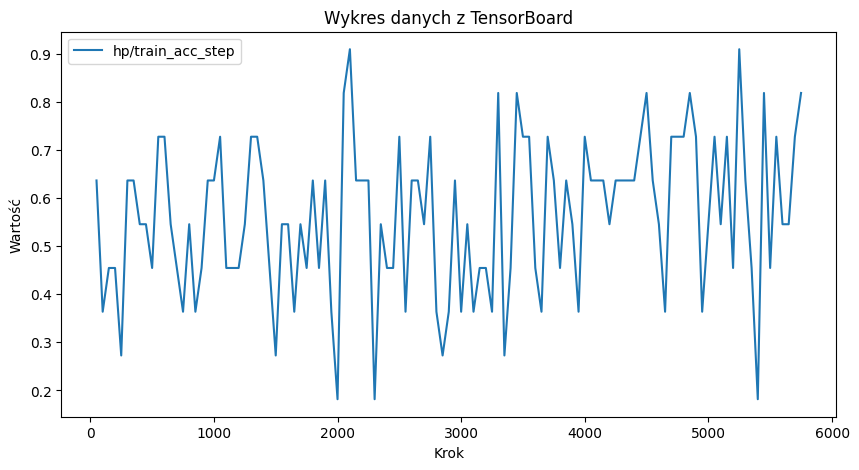

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def load_tensorboard_scalars(logdir):
    # Tworzy akumulator do odczytu danych
    ea = event_accumulator.EventAccumulator(logdir,
        size_guidance={event_accumulator.SCALARS: 0})  # 0 = bez ograniczeń
    ea.Reload()  # Wczytaj wszystkie dane z dysku

    # Odczyt danych skalarnych
    scalars = {}
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        scalars[tag] = [(e.wall_time, e.step, e.value) for e in events]

    return scalars

# Ścieżka do katalogu z logami TensorBoard
logdir = '/home/daniel/repos/Decoding_of_EEG/lightning_logs/CWT_EEG/version_51/events.out.tfevents.1713204451.pop-os.32833.5'

# Wczytanie danych
scalars = load_tensorboard_scalars(logdir)

# Przykład wyświetlenia danych skalarnych
tag = 'hp/train_acc_step'  # Zmień na odpowiedni tag, który chcesz wyświetlić
times, steps, values = zip(*scalars[tag])

plt.figure(figsize=(10, 5))
plt.plot(steps, values, label=tag)
plt.xlabel('Krok')
plt.ylabel('Wartość')
plt.title('Wykres danych z TensorBoard')
plt.legend()
plt.show()
